In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from time import time
import numpy as np
from util._telegram import send_simple_message

# Data Stuff

In [3]:
distances = None

In [4]:
EXPERIMENT_ID = 436
EXPERIMENT_FODLER = Path("experiments", "20230327183259_results_nb", f"{str(EXPERIMENT_ID).zfill(5)}_individuals")
ONLY_MAIN_CHARTS = True
CLUSTER_ID = 5

In [5]:
DLIB_DISTANCES_FILE = Path("fr", "distances_dlib.json")
RESNET_DISTANCES_FILE = Path("fr", "distances_resnet.json")
RESNET_FACEPARTS_DISTANCES_FILE = Path("fr", "distances_resnet_faceparts.json")
DLIB_DATASET_CLUSTERS_FILE = Path("fr", "dlib_clusters.json")

DLIB_RESNET_BEST_COMB = EXPERIMENT_FODLER.joinpath("best_individual.json")
DLIB_RESNET_BEST_COMBS = EXPERIMENT_FODLER.joinpath("best_individuals.json")

PRECISION_RECALL_FILE_PATH = EXPERIMENT_FODLER.joinpath(f"precision_recall.json")

In [6]:
# Load distances from raw files into dataframes

# DLIB Distances ( <pair>: {'dlib': distance}} )
if distances is None:
    tmp_raw_data = json.load(open(DLIB_DISTANCES_FILE, "r"))
    dlib_distances = pd.DataFrame(dict(pair=tmp_raw_data.keys(), dlib_distance=(d['dlib'] for d in tmp_raw_data.values())))
    del tmp_raw_data

    # ResNET Distances ({<pair>: distance})
    tmp_raw_data = json.load(open(RESNET_DISTANCES_FILE, "r"))
    resnet_distances = pd.DataFrame(dict(pair=tmp_raw_data.keys(), resnet_distance=tmp_raw_data.values()))
    del tmp_raw_data

    # ResNET Faceparts Distances
    def rows_generator(resnet_faceparts_raw_data):
        for pair, distances in resnet_faceparts_raw_data.items():
            distances.update({'pair': pair})
            yield distances

    tmp_raw_data = json.load(open(RESNET_FACEPARTS_DISTANCES_FILE, "r"))
    generator = rows_generator(tmp_raw_data)
    del tmp_raw_data

    resnet_faceparts_distances = pd.DataFrame(generator)

    # Join distances into a sigle dataframe
    distances = dlib_distances.merge(resnet_distances, on='pair', how='outer')
    distances = distances.merge(resnet_faceparts_distances, on='pair', how='outer')

    # Filter only images with "n" (from VGGFACE2)
    distances = distances[distances.pair.apply(lambda p: "n" in p)]

    # Generate extra columns
    distances["img1"] = distances.pair.apply(lambda p: p.split(" x ")[0])
    distances["img2"] = distances.pair.apply(lambda p: p.split(" x ")[1])
    distances["person1"] = distances.img1.apply(lambda p: p.split("_")[0])
    distances["person2"] = distances.img2.apply(lambda p: p.split("_")[0])
    distances["same_person"] = (distances.person1 == distances.person2).apply(lambda s: "same" if s else "different")

    # Delete unnecessary columns
    distances.drop(columns='pair', inplace=True)

    # Sort columns by name
    distances = distances.reindex(sorted(distances.columns), axis=1)

    # Load clusters
    if CLUSTER_ID is not None:
        clusters_ref = pd.DataFrame(data=json.load(open(DLIB_DATASET_CLUSTERS_FILE, "r")))
        clusters_ref.set_index('label', inplace=True)

        distances['img1_cluster'] = distances.img1.apply(lambda i: clusters_ref.cluster.get(i, None))
        distances['img2_cluster'] = distances.img2.apply(lambda i: clusters_ref.cluster.get(i, None))

        distances = distances[(distances.img1_cluster == CLUSTER_ID) & (distances.img2_cluster == CLUSTER_ID)]

        del clusters_ref

    # Normalize distances
    distances_num = distances.select_dtypes(include="number")
    for col in distances_num.columns:
        distances_num[col] = (distances_num[col]-distances_num[col].min())/(distances_num[col].max()-distances_num[col].min())

    distances[distances_num.columns] = distances_num

    del dlib_distances
    del resnet_distances
    del resnet_faceparts_distances
    del distances_num

### Calculate best combination

In [7]:
# Load best combination of dlib and resnet
dlib_resnet_best_comb = json.load(open(DLIB_RESNET_BEST_COMB, "r"))
dlib_resnet_best_comb = pd.DataFrame(dict(resnet_part=dlib_resnet_best_comb.keys(), multiplier=dlib_resnet_best_comb.values()))
dlib_resnet_best_comb.sort_values(by="resnet_part", inplace=True)

# Calculate resnet_combination column
best_multipliers_lst = dlib_resnet_best_comb.multiplier.tolist()
individual_sum = sum(best_multipliers_lst)
best_multipliers_lst = [i/individual_sum for i in best_multipliers_lst]
distances["resnet_comb"] = distances.loc[:, dlib_resnet_best_comb.resnet_part].dot(best_multipliers_lst)

# Plots

In [8]:
# Utilitaty funcion for charts
def next_axis(rows, cols):
    i = 0
    j = 0
    while True:
        yield (i, j)
        j += 1
        if j == cols:
            j = 0
            i += 1
        
        if i > rows:
            break

In [9]:
COLUMNS_TO_IGNORE = ["person1", "person2", "img1", "img2", "same_person", "img1_cluster", "img2_cluster"]

### Best Combination Search

In [10]:
dlib_resnet_best_combs = pd.DataFrame(json.load(open(DLIB_RESNET_BEST_COMBS, "r")))

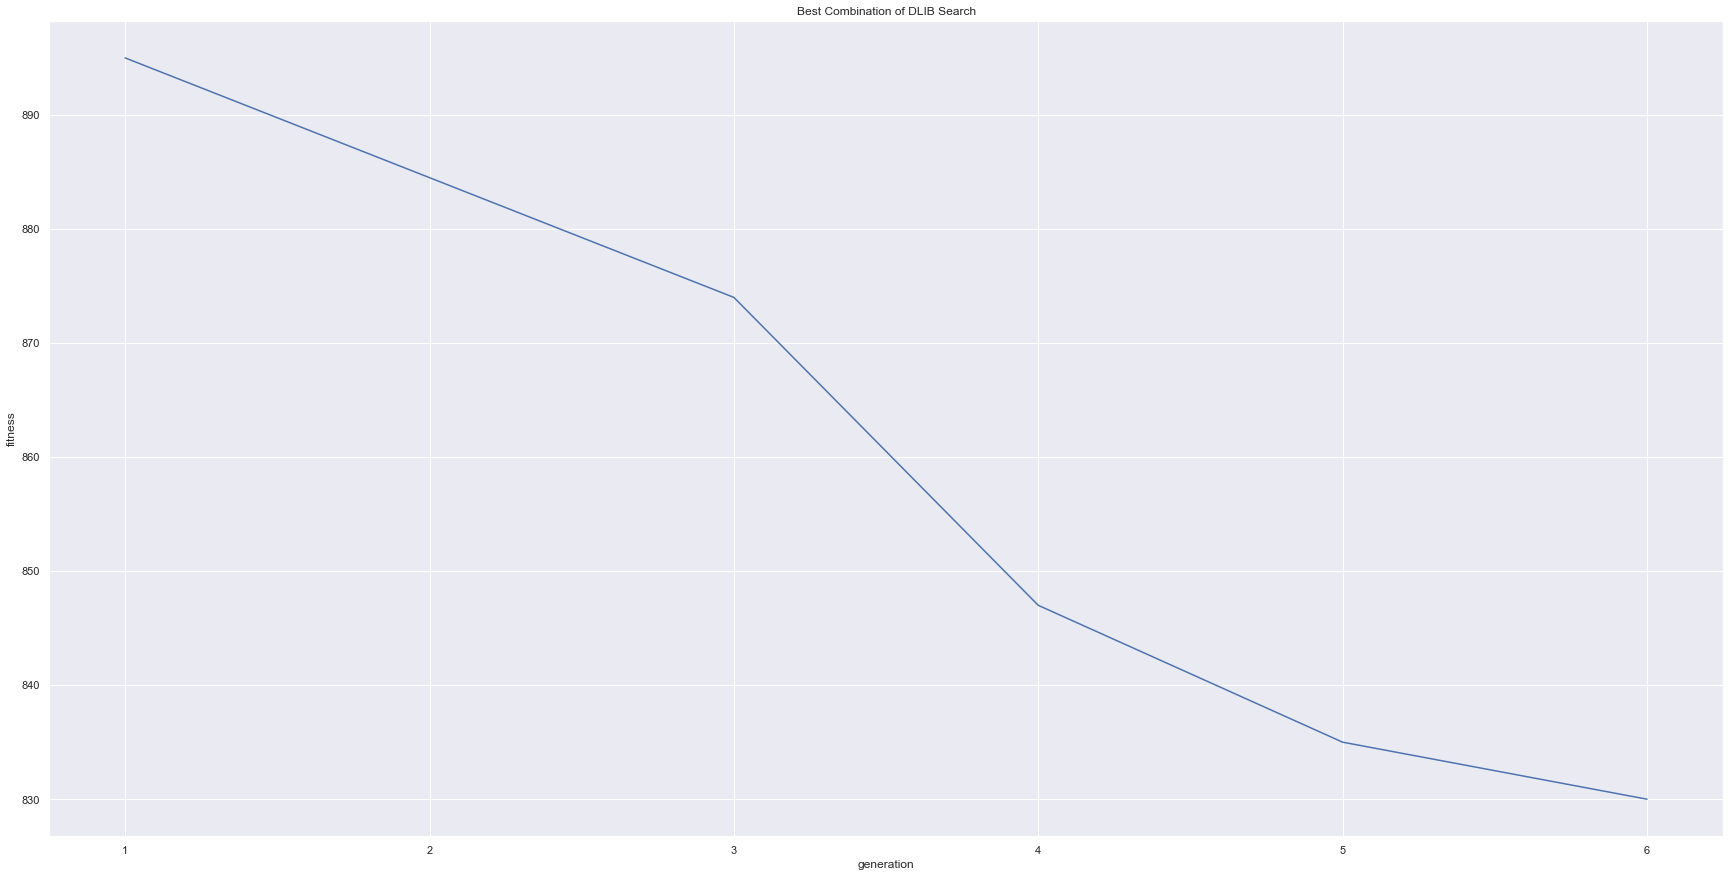

In [12]:
sns.set(rc={"figure.figsize": (30,15)})
ax = sns.lineplot(x="generation", y="fitness", data=dlib_resnet_best_combs)
ax = ax.set_title("Best Combination of DLIB Search")

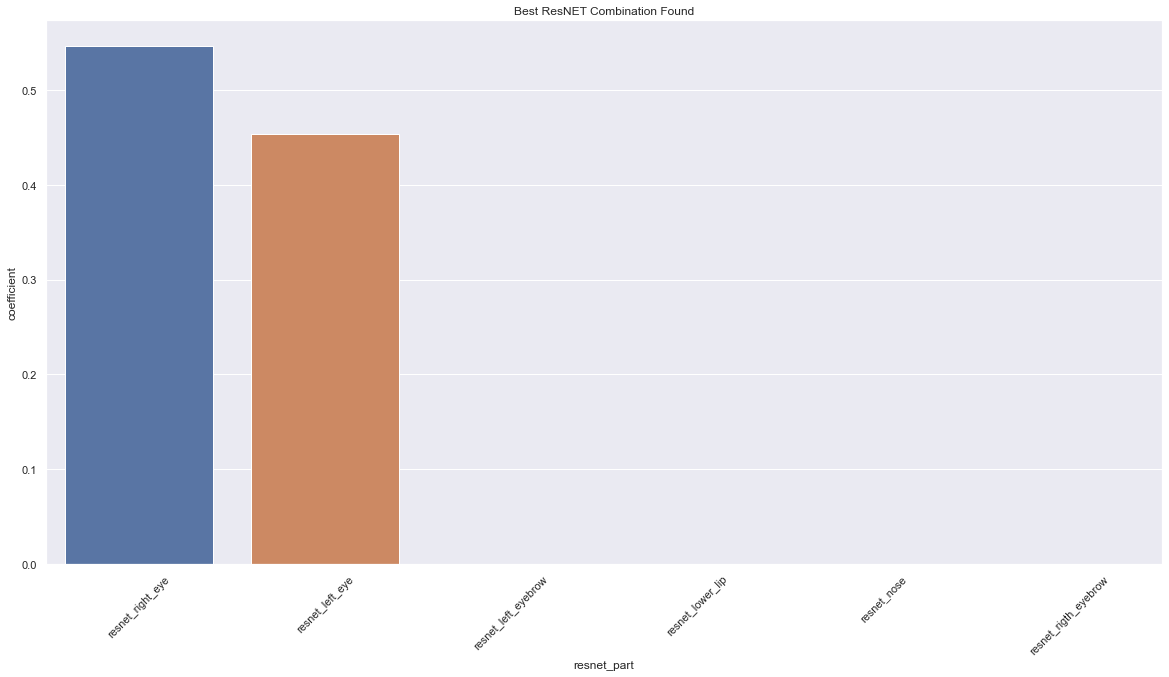

In [17]:
sns.set(rc={"figure.figsize": (20,10)})
plot_data = dlib_resnet_best_combs.iloc[-1].best_data
plot_data = pd.DataFrame(dict(resnet_part=plot_data.keys(), coefficient=plot_data.values()))
plot_data.coefficient = plot_data.coefficient / plot_data.coefficient.sum()
plot_data.sort_values(by="coefficient", inplace=True, ascending=False)
ax = sns.barplot(x="resnet_part", y="coefficient", data=plot_data)
ax = ax.set_title("Best ResNET Combination Found")
_ = plt.xticks(rotation=45)

### Correlation Matrix

In [18]:
if not ONLY_MAIN_CHARTS:
    sns.set(rc={"figure.figsize": (30,20)})
    corr = distances.corr()
    plt.matshow(corr)
    plt.xticks(range(distances.select_dtypes(['number']).shape[1]), distances.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(distances.select_dtypes(['number']).shape[1]), distances.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix (Pearson)', fontsize=16)

    for (i, j), z in np.ndenumerate(corr):
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', size=14)

### Distances Correlation with DLIB

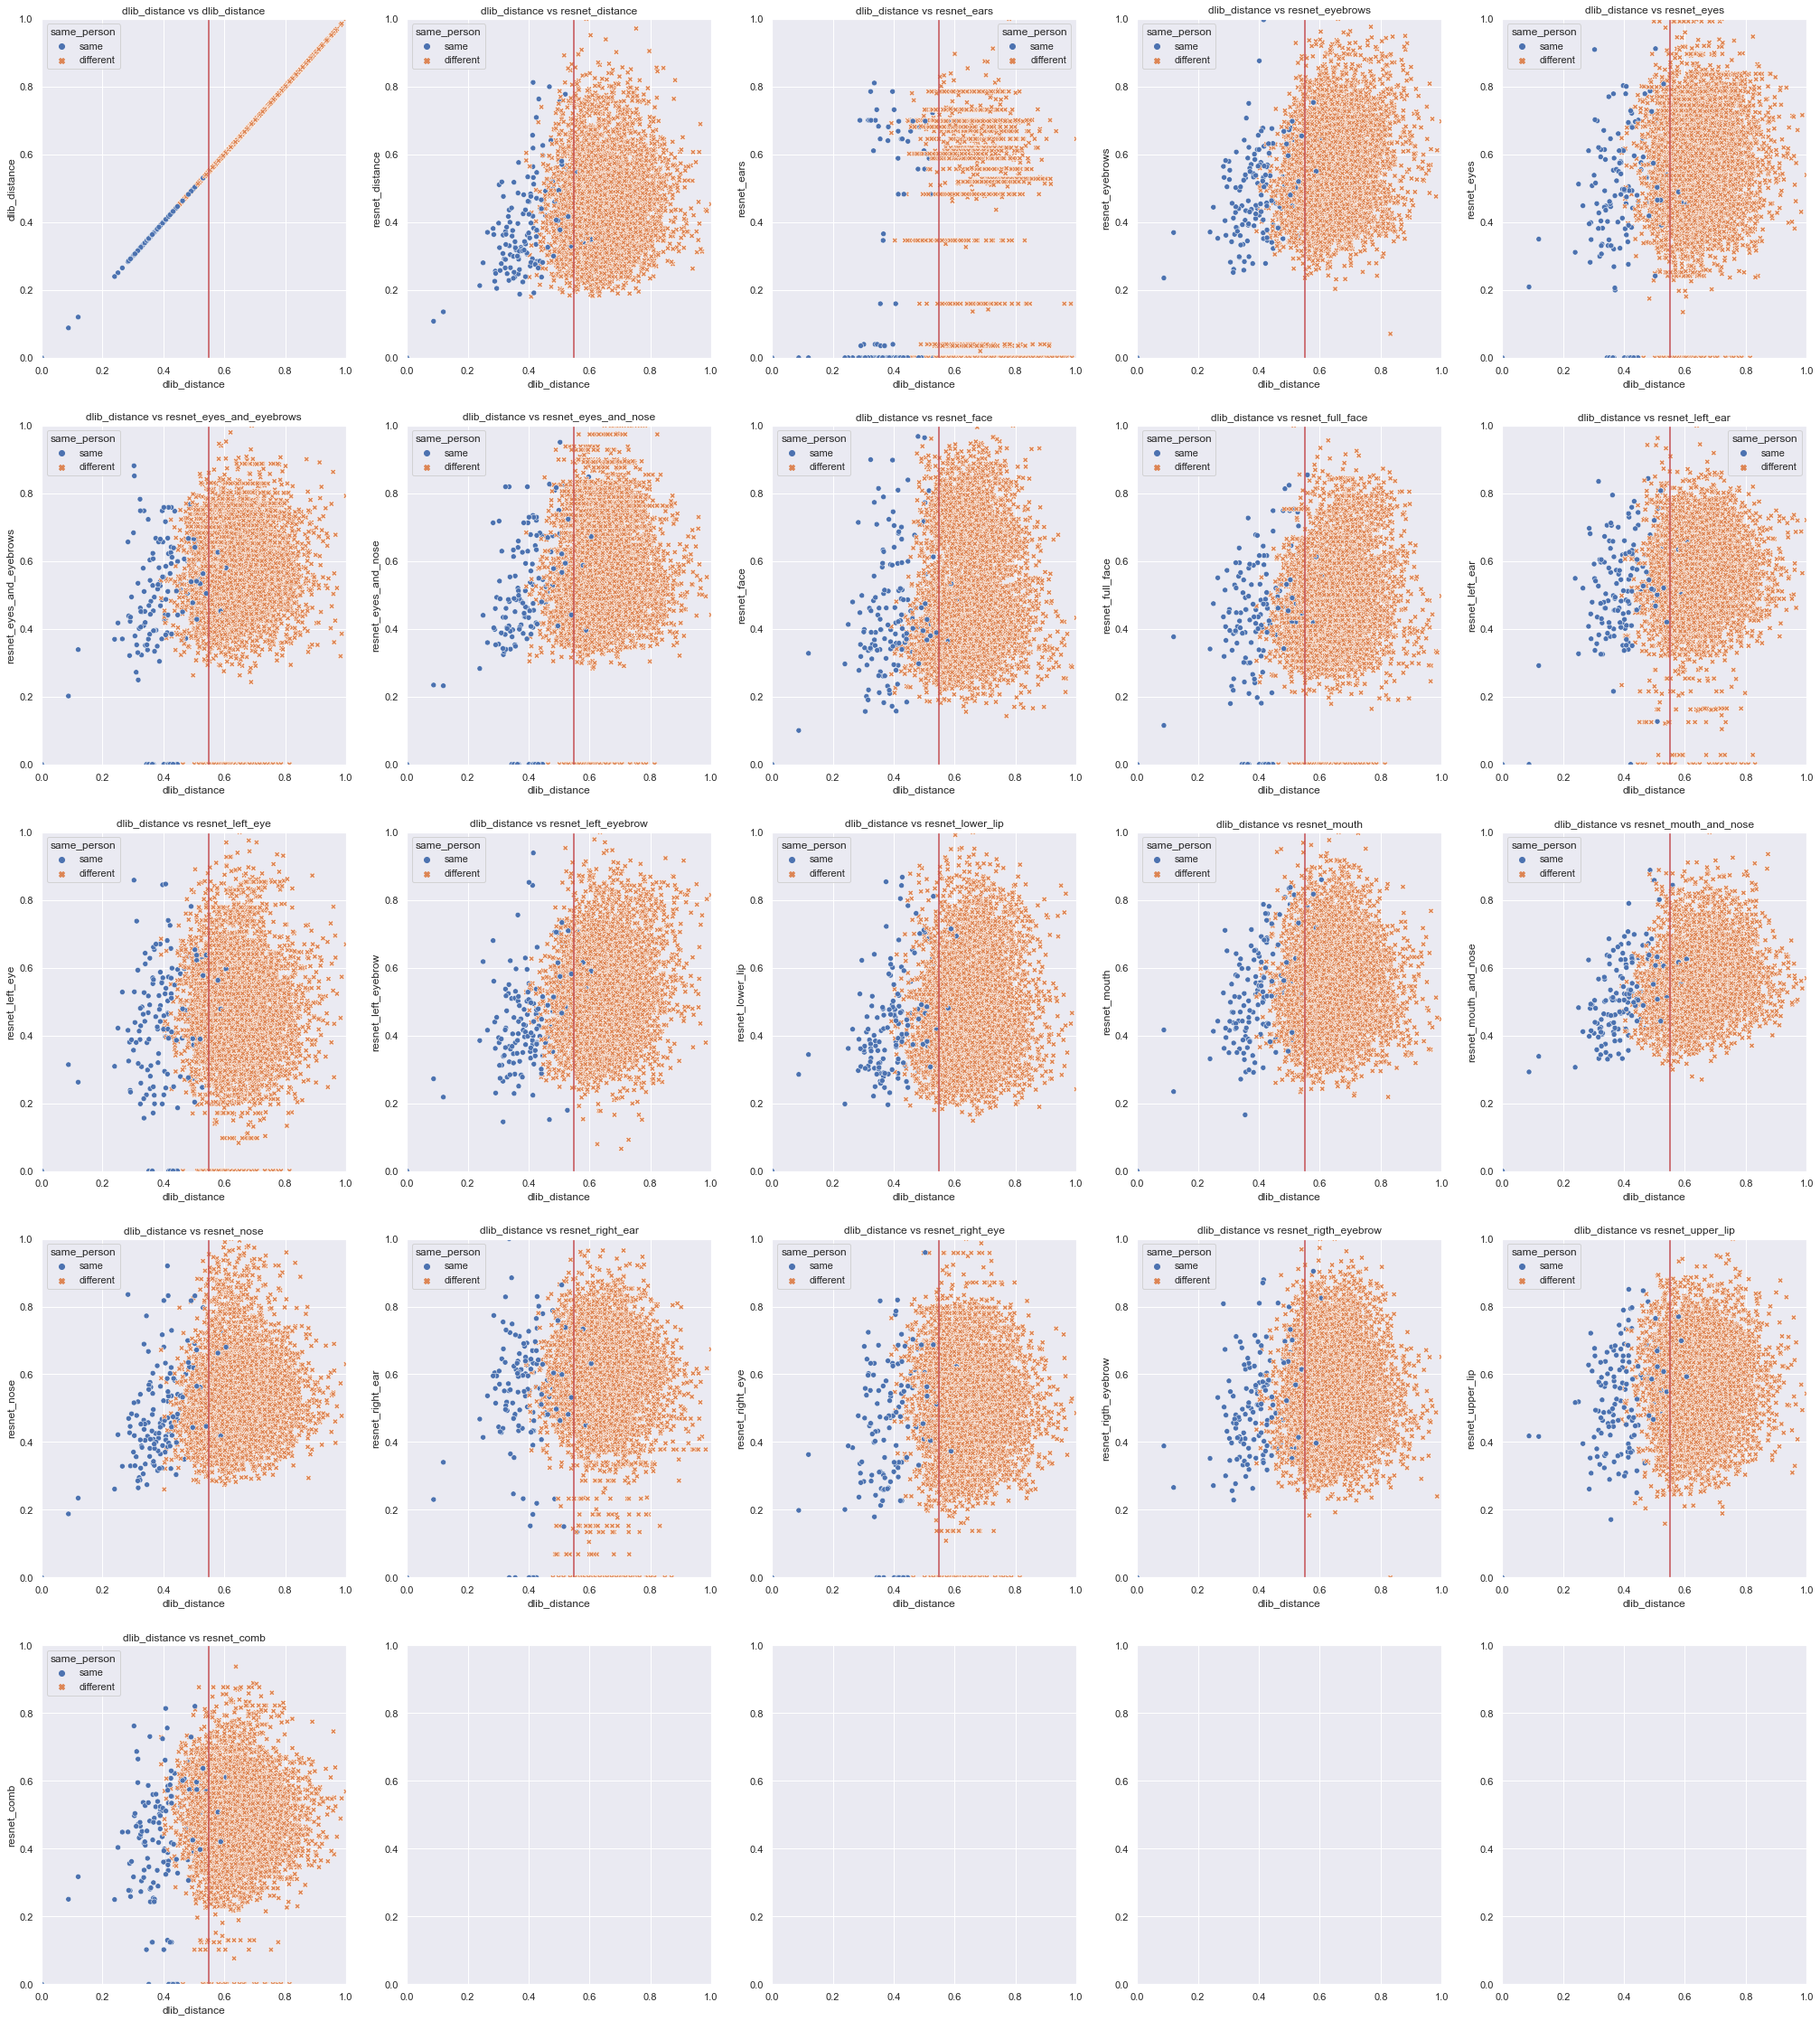

In [19]:
ROWS = 5
COLS = 5
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(35,40))

dlib_col = "dlib_distance"
make_idx_generator = next_axis(rows=ROWS, cols=COLS)
columns = list(distances.columns)
for distance_col in columns:
    if distance_col in COLUMNS_TO_IGNORE:
        continue
    row_idx, col_idx = make_idx_generator.__next__()
    axes[row_idx, col_idx].set_title(f'dlib_distance vs {distance_col}')
    g = sns.scatterplot(ax=axes[row_idx, col_idx], x=dlib_col, y=distance_col, data=distances, hue='same_person', style='same_person')
    # g = sns.histplot(ax=axes[row_idx, col_idx], data=distances, x=dlib_col, y=distance_col, hue="same_person", fill=True, kde=True)
    g.axvline(0.55, color='r')
    g.set(xlim=(0,1), ylim=(0, 1))

### Distances Correlation with DLIB (Only pairs of same persons)

In [20]:
if not ONLY_MAIN_CHARTS:
    ROWS = 5
    COLS = 5
    fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(35,40))

    dlib_col = "dlib_distance"
    make_idx_generator = next_axis(rows=ROWS, cols=COLS)
    columns = list(distances.columns)
    for distance_col in columns:
        if distance_col in COLUMNS_TO_IGNORE:
            continue
        row_idx, col_idx = make_idx_generator.__next__()
        axes[row_idx, col_idx].set_title(f'dlib_distance vs {distance_col}')
        # g = sns.scatterplot(ax=axes[row_idx, col_idx], x=dlib_col, y=distance_col, data=distances[distances.same_person == "same"], hue='same_person', style='same_person')
        g = sns.histplot(ax=axes[row_idx, col_idx], data=distances[distances.same_person == "same"], x=dlib_col, y=distance_col, hue="same_person", fill=True, kde=True)
        g.axvline(0.55, color='r')
        g.set(xlim=(0,1), ylim=(0, 1))

### Distances Correlation with DLIB (Only pairs of different persons)

In [21]:
if not ONLY_MAIN_CHARTS:
    ROWS = 5
    COLS = 5
    fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(35,40))

    dlib_col = "dlib_distance"
    make_idx_generator = next_axis(rows=ROWS, cols=COLS)
    columns = list(distances.columns)
    for distance_col in columns:
        if distance_col in COLUMNS_TO_IGNORE:
            continue
        row_idx, col_idx = make_idx_generator.__next__()
        axes[row_idx, col_idx].set_title(f'dlib_distance vs {distance_col}')
        # g = sns.scatterplot(ax=axes[row_idx, col_idx], x=dlib_col, y=distance_col, data=distances[distances.same_person != "same"], style='same_person', color="orange")
        g = sns.histplot(ax=axes[row_idx, col_idx], data=distances[distances.same_person != "same"], x=dlib_col, y=distance_col, hue="same_person", fill=True, kde=True, color="orange")
        
        g.axvline(0.55, color='r')
        g.set(xlim=(0,1), ylim=(0, 1))

### Distances Distribution

In [22]:
if not ONLY_MAIN_CHARTS:
    ROWS = 5
    COLS = 5

    columns = list(distances.columns)
    idx_generator = next_axis(rows=ROWS, cols=COLS)
    fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(35,30))
    for tmp_col in columns:
        if tmp_col in COLUMNS_TO_IGNORE:
            continue
        row_idx, col_idx = idx_generator.__next__()
        axes[row_idx, col_idx].set_title(f"{tmp_col}")
        ax1 = sns.histplot(ax=axes[row_idx, col_idx], data=distances[tmp_col], bins=100, kde=True)
        ax1.set_xlabel("Distâncias")
        ax1.set_ylabel("Quantidade")
        ax1.set(xlim=(0,1))

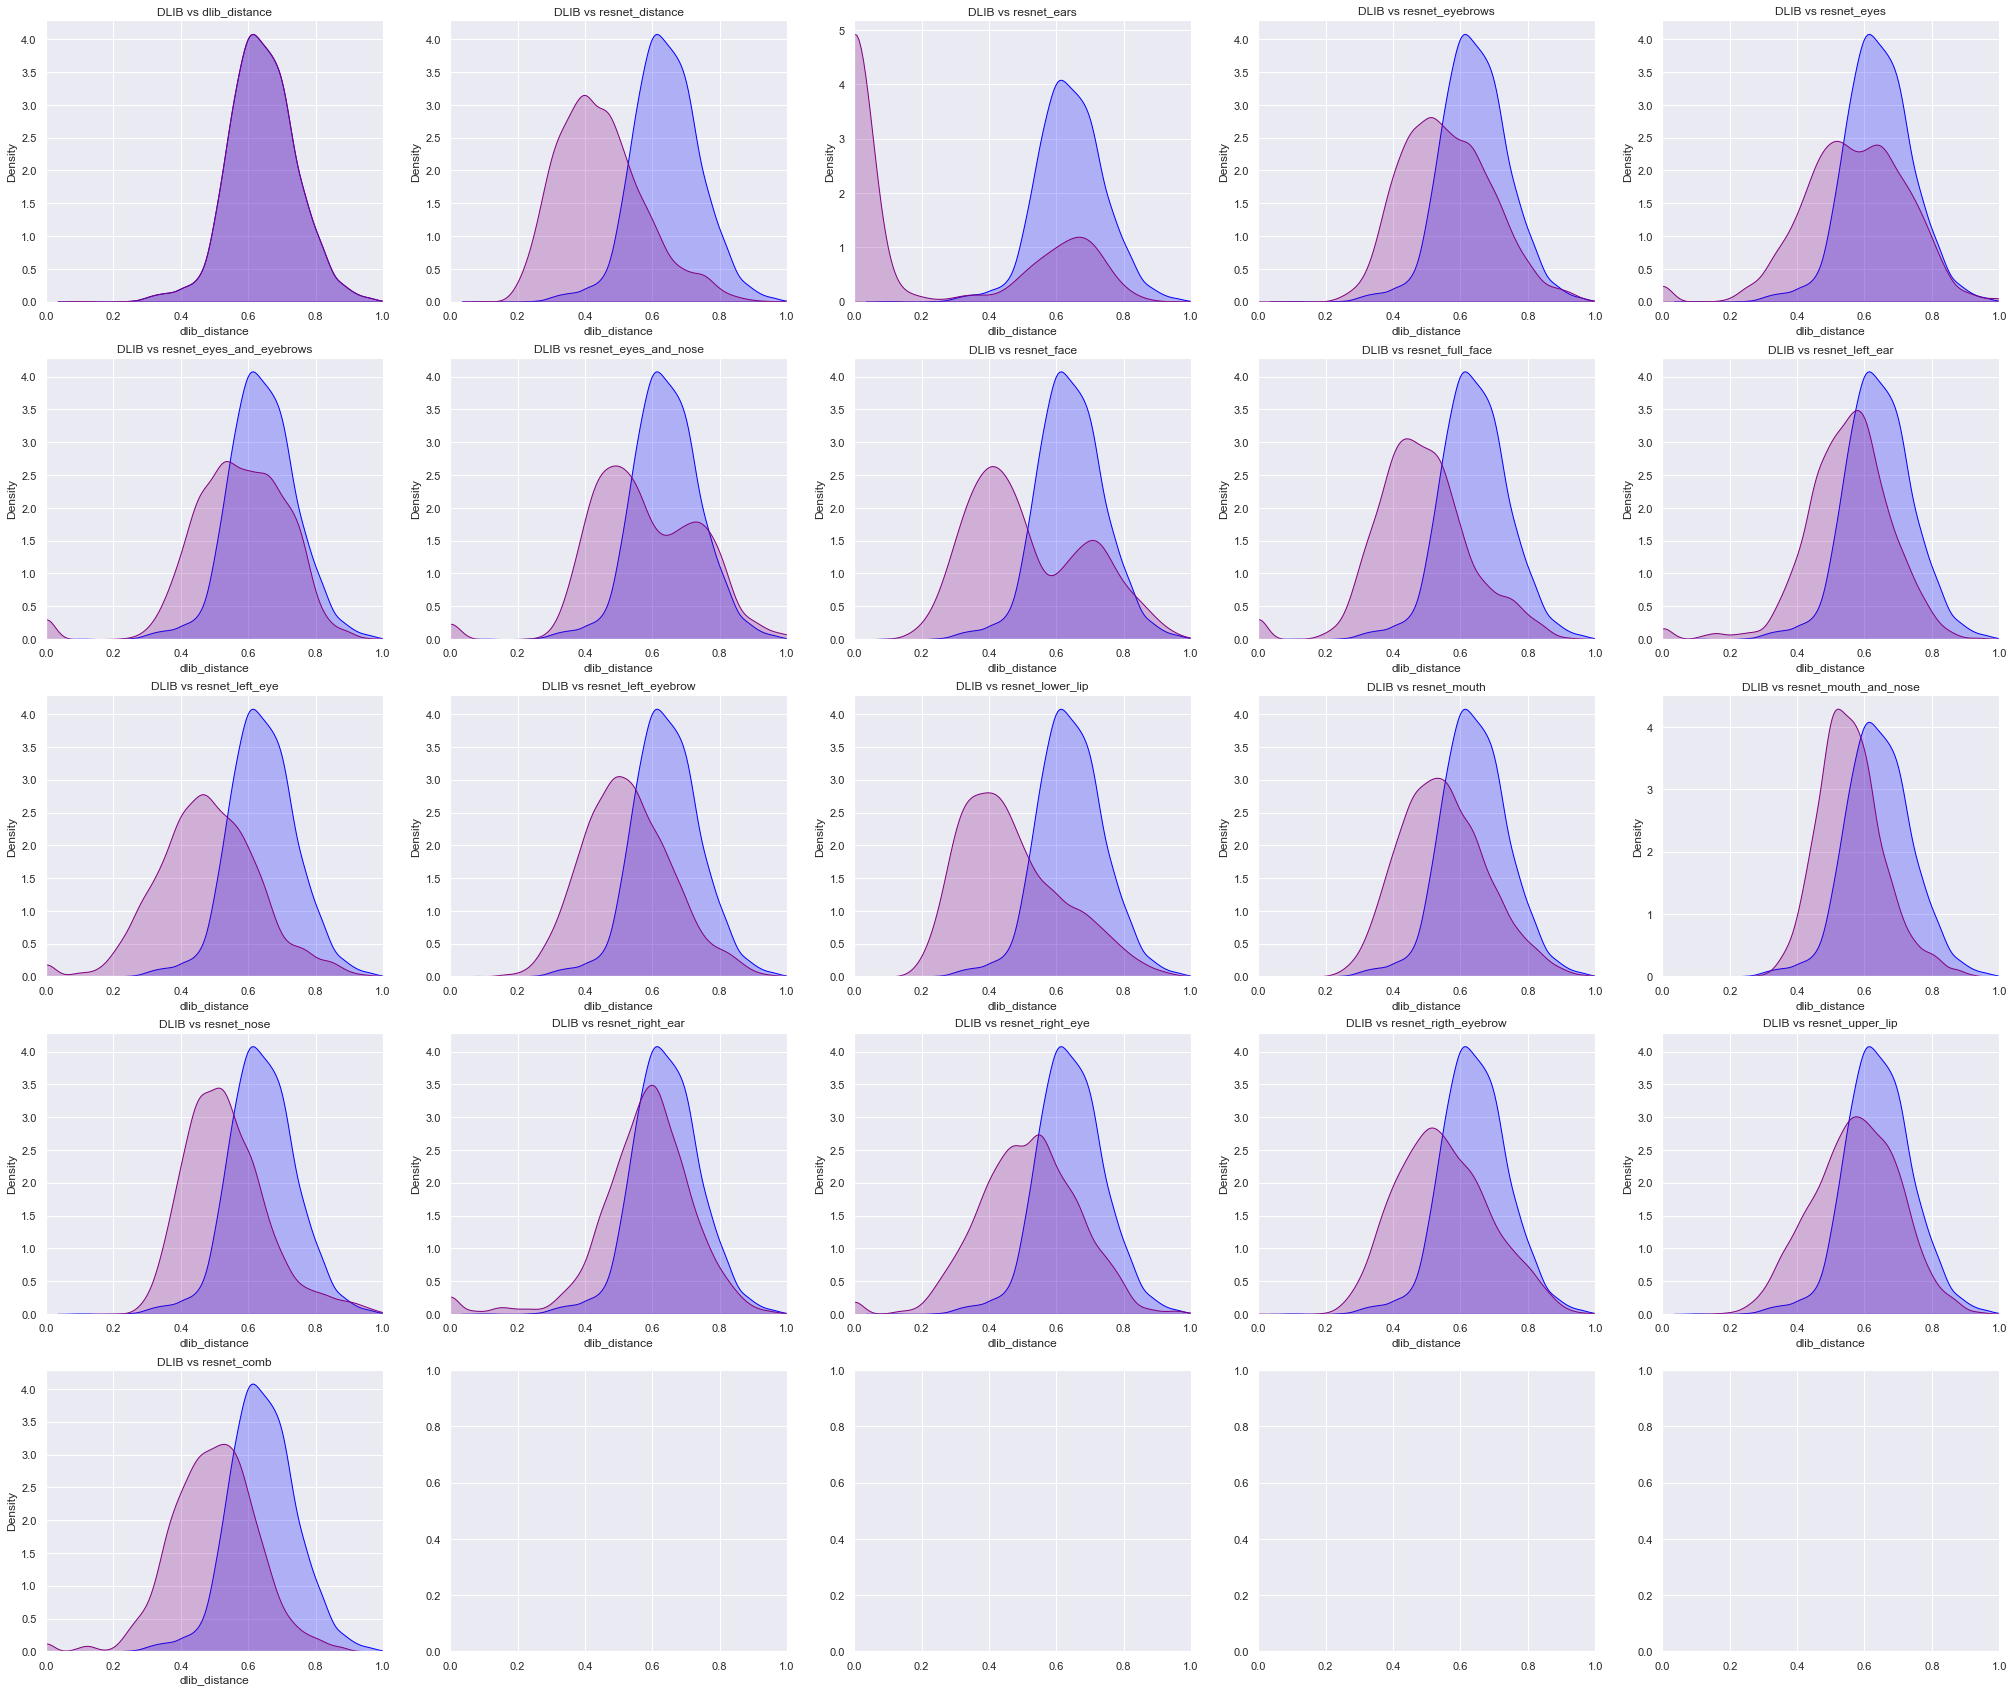

In [23]:
ROWS = 5
COLS = 5
columns = list(distances.columns)
idx_generator = next_axis(rows=ROWS, cols=COLS)
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(35,30))
for tmp_col in columns:
    if tmp_col in COLUMNS_TO_IGNORE:
        continue

    row_idx, col_idx = idx_generator.__next__()
    axes[row_idx, col_idx].set_title(f"DLIB vs {tmp_col}")
    ax = sns.kdeplot(ax=axes[row_idx, col_idx], data=distances[(distances.img1 != distances.img2)]["dlib_distance"], color="blue", shade=True)
    ax = sns.kdeplot(ax=axes[row_idx, col_idx], data=distances[(distances.img1 != distances.img2)][tmp_col], color="purple", shade=True)
    ax.set(xlim=(0,1))

### Distances Distribution (Same person vs Different persons)

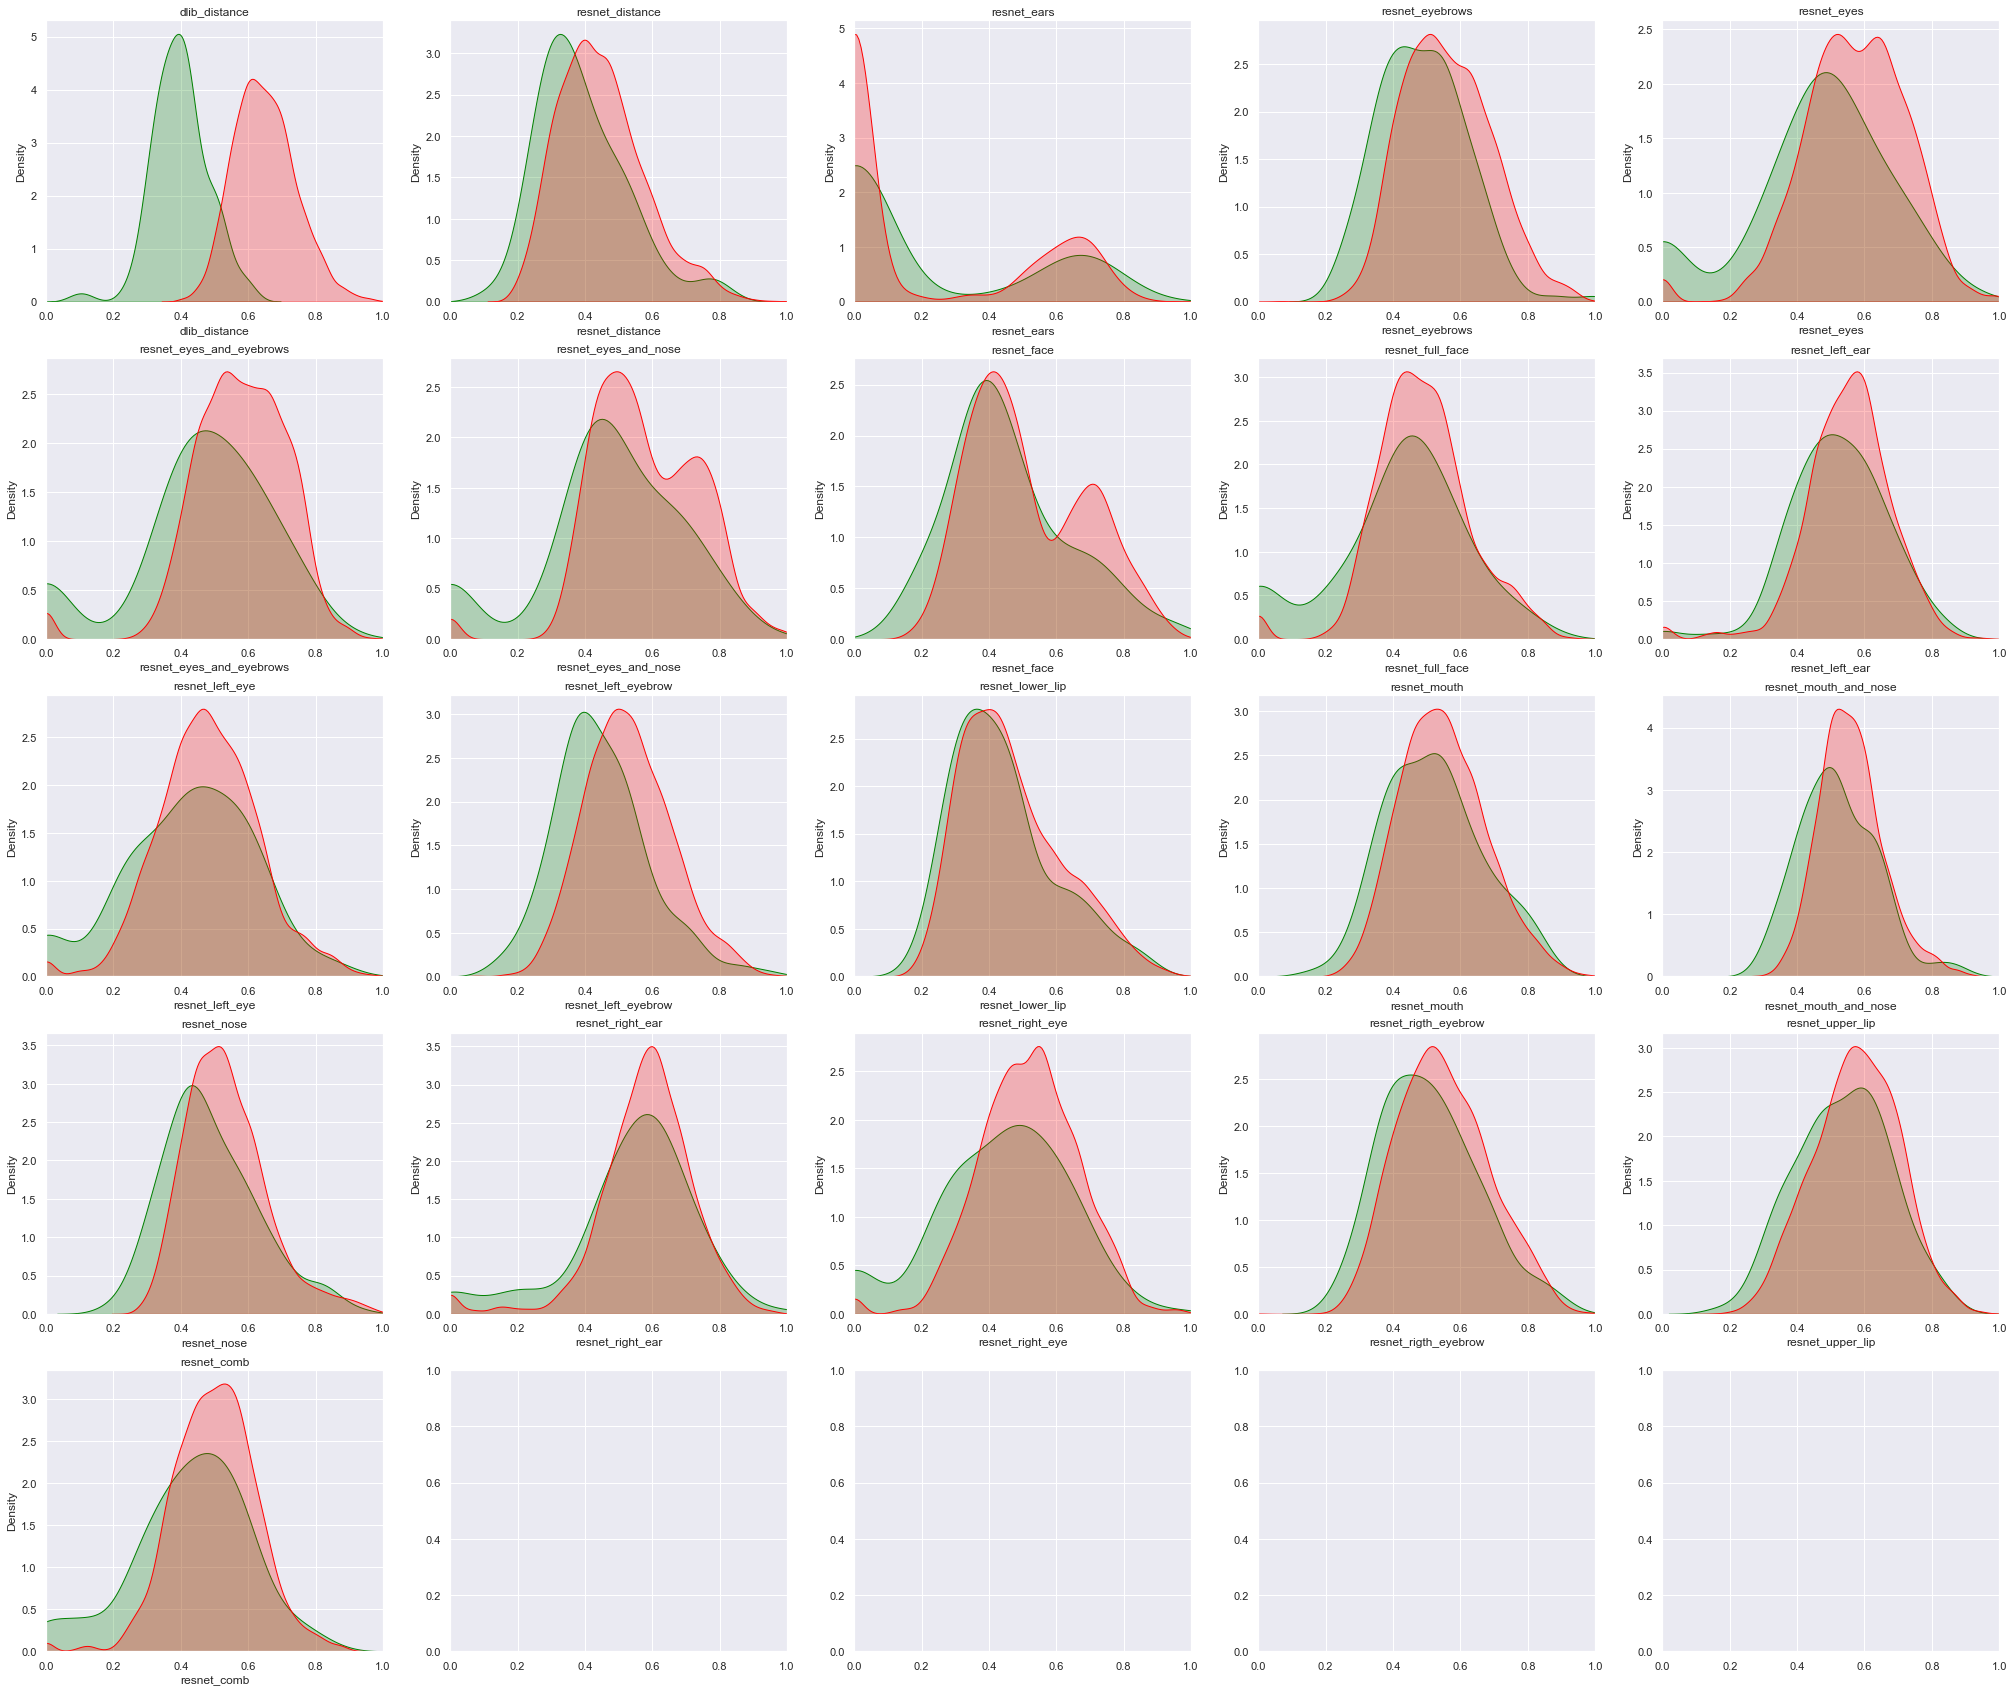

In [24]:
ROWS = 5
COLS = 5
columns = list(distances.columns)
idx_generator = next_axis(rows=ROWS, cols=COLS)
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(35,30))
for tmp_col in columns:
    if tmp_col in COLUMNS_TO_IGNORE:
        continue

    row_idx, col_idx = idx_generator.__next__()
    axes[row_idx, col_idx].set_title(f"{tmp_col}")
    ax = sns.kdeplot(ax=axes[row_idx, col_idx], data=distances[(distances.same_person == "same") & (distances.img1 != distances.img2)][tmp_col], color="green", shade=True)
    ax = sns.kdeplot(ax=axes[row_idx, col_idx], data=distances[distances.same_person != "same"][tmp_col], color="red", shade=True)
    ax.set(xlim=(0,1))

# Person Recovery Analysis

In [25]:
if not ONLY_MAIN_CHARTS:
    # Try recover the precision and recall from the excel file
    try:
        precision_recall = pd.DataFrame(json.load(open(PRECISION_RECALL_FILE_PATH, "r")))
        print(f"Precision vs Recall data recovered from {PRECISION_RECALL_FILE_PATH}")
    except Exception as e:
        print(e)
        precision_recall = None

    # If the excel file is not found, calculate precion vs recall and save to file
    if precision_recall is None:
        start_total_time = time()
        persons = list(distances.person1.unique())
        cols = list(distances.columns)
        recovered_results = []
        for c in cols:

            if c in COLUMNS_TO_IGNORE:
                continue

            print(f"Calculating Precision vs Recall for col {c}")

            start_time = time()

            # Calculalate how many images method (columns of distaneces) get right for each person
            distances.sort_values(by=[c], inplace=True)
            for person in persons:
                person_imgs_count = distances[(distances.person1 == person) & (distances.same_person == "same")].shape[0]
                for imgs_to_recover in range(1, person_imgs_count, 1):
                    recovered = distances[distances['person1'] == person].head(imgs_to_recover)
                    imgs_of_person_recovered = recovered[(recovered.same_person == "same")].shape[0]
                    wrong_recovered = recovered[recovered.person2 != person].shape[0]
                    recovered_results.append({
                                                "method": c,
                                                "person": person,
                                                "imgs_of_person": person_imgs_count,
                                                "imgs_recovered": imgs_to_recover,  
                                                "imgs_of_person_recovered": imgs_of_person_recovered,
                                                "wrong_recovered": wrong_recovered,
                                                "max_imgs_of_person_available": min(imgs_to_recover, person_imgs_count),
                                            })

            precision_recall = pd.DataFrame(recovered_results)
            precision_recall['precision'] = precision_recall.imgs_of_person_recovered / precision_recall.max_imgs_of_person_available
            precision_recall['recall'] = precision_recall.imgs_of_person_recovered / precision_recall.imgs_of_person
            precision_recall.to_json(PRECISION_RECALL_FILE_PATH, orient="records")

            print(f"Precision vs Recall done for col {c} in {(time() - start_time) // 60} minutes.")
            send_simple_message(f"Precision vs Recall done for col {c} in {(time() - start_time) // 60} minutes.")

        print(f"Precision vs Recall done for all columns in {(time() - start_total_time) // 60} minutes.")
        send_simple_message(f"Precision vs Recall done for all columns in {(time() - start_total_time) // 60} minutes.")


In [26]:
if not ONLY_MAIN_CHARTS:
    plot_data = precision_recall.loc[:, ["method", "precision", "recall"]]
    dlib_data = precision_recall[precision_recall.method == "dlib_distance"]
    resnet_data = precision_recall[precision_recall.method == "resnet_distance"]

    ROWS = 4
    COLS = 5
    methods = list(plot_data.method.unique())
    idx_generator = next_axis(rows=ROWS, cols=COLS)
    fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(35,30))
    for tmp_method in methods:
        if tmp_method == "dlib_distance" or tmp_method == "resnet_distance" or tmp_method == "same":
            continue

        row_idx, col_idx = idx_generator.__next__()
        axes[row_idx, col_idx].set_title("Precision vs Recall")
        ax1 = sns.lineplot(ax=axes[row_idx, col_idx], x="recall", y="precision", data=dlib_data, color="green")
        ax1 = sns.lineplot(ax=axes[row_idx, col_idx], x="recall", y="precision", data=resnet_data, color="blue")
        ax1 = sns.lineplot(ax=axes[row_idx, col_idx], x="recall", y="precision", data=plot_data[plot_data.method == tmp_method], color="red")
        _ = ax1.set_xlabel("Recall")
        _ = ax1.set_ylabel("Precision")
        _ = ax1.set_title(f"Precision vs Recall {tmp_method}")

In [27]:
# send_simple_message("ResNET Experiment Analysis done.")

In [28]:
len(distances.img1.unique())

103